In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

1.0

In [4]:
target = df['NObeyesdad'].astype('category').cat.codes
df = df.drop('NObeyesdad', axis=1)

df['FAVC'] = df['FAVC'].apply(lambda x: int(x == "yes"))
df['SCC'] = df['SCC'].apply(lambda x: int(x == "yes"))
df['SMOKE'] = df['SMOKE'].apply(lambda x: int(x == "yes"))
df['family_history_with_overweight'] = df['family_history_with_overweight'].apply(lambda x: int(x == "yes"))

df = pd.get_dummies(df, columns=['Gender', 'MTRANS', 'CAEC', 'CALC'], dtype=int)

scaler = StandardScaler()
df = scaler.fit_transform(df)

df

array([[-0.52212439, -0.87558934, -0.86255819, ..., -0.18519426,
        -1.40472041,  1.5177613 ],
       [-0.52212439, -1.94759928, -1.16807699, ..., -0.18519426,
         0.71188543, -0.65886513],
       [-0.20688898,  1.05402854, -0.36609013, ...,  5.39973544,
        -1.40472041, -0.65886513],
       ...,
       [-0.28190933,  0.54167211,  1.79886776, ..., -0.18519426,
         0.71188543, -0.65886513],
       [ 0.00777624,  0.40492652,  1.78577968, ..., -0.18519426,
         0.71188543, -0.65886513],
       [-0.10211908,  0.39834438,  1.7905916 , ..., -0.18519426,
         0.71188543, -0.65886513]])

In [22]:
# my implementation

from KNNClassifier import KNNClassifier

X_train, X_test, y_train, y_test = train_test_split(df, target.values, train_size=0.7)

model = KNNClassifier(k=3)
model.fit(X_train, y_train)
prediction = model.predict(X_test)

model_score = accuracy_score(y_test, prediction)
model_score

0.831230283911672

In [23]:
# library implementation

from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

lib = KNeighborsClassifier(n_neighbors=3)
lib.fit(X_train, y_train)
lib_prediction = lib.predict(X_test)

lib_score = accuracy_score(y_test, lib_prediction)
lib_score

0.831230283911672

In [26]:
# hyperparameter optimization

import optuna
from sklearn.model_selection import cross_val_score

def model_objective(trial):
    kernel = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'chebyshev', 'cosine'])
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 5)
    else:
        p = 2 # does not matter
    window_fixed = trial.suggest_categorical('fixed', [True, False])
    if window_fixed:
        if metric == 'cosine':
            window_size = trial.suggest_float('window_size', 1.0, 2.0, step=0.1)
        else:
            window_size = trial.suggest_float('window_size', 60, 100, step=2)
        classifier = KNNClassifier(window_size=window_size, metric=metric, p=p, kernel=kernel)
    else:
        k = trial.suggest_int('k', 1, 20)
        classifier = KNNClassifier(k=k, metric=metric, p=p, kernel=kernel)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=1
    )
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(model_objective, n_trials=100)

[I 2024-04-25 18:53:42,688] A new study created in memory with name: no-name-03b0f67f-d92e-48f2-b1ef-82bc6761e80e
[I 2024-04-25 18:54:40,388] Trial 0 finished with value: 0.43939303710490146 and parameters: {'kernel': 'epanechnikov', 'metric': 'cosine', 'fixed': True, 'window_size': 1.3}. Best is trial 0 with value: 0.43939303710490146.
[I 2024-04-25 18:55:00,356] Trial 1 finished with value: 0.7691250572606505 and parameters: {'kernel': 'epanechnikov', 'metric': 'chebyshev', 'fixed': False, 'k': 1}. Best is trial 1 with value: 0.7691250572606505.
[I 2024-04-25 18:55:01,394] Trial 2 finished with value: 0.7765460375629868 and parameters: {'kernel': 'uniform', 'metric': 'minkowski', 'p': 5, 'fixed': False, 'k': 2}. Best is trial 2 with value: 0.7765460375629868.
[I 2024-04-25 18:55:54,545] Trial 3 finished with value: 0.7724896930829134 and parameters: {'kernel': 'uniform', 'metric': 'cosine', 'fixed': False, 'k': 5}. Best is trial 2 with value: 0.7765460375629868.
[I 2024-04-25 18:56:1

In [27]:
model_params = study.best_params
study.best_value, model_params

(0.8449404489234997,
 {'kernel': 'epanechnikov',
  'metric': 'minkowski',
  'p': 1,
  'fixed': False,
  'k': 6})

In [28]:
def lib_objective(trial):
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'cosine', 'chebyshev'])
    if metric == 'minkowski':
        p = trial.suggest_int('p', 1, 5)
    else:
        p = 2 # does not matter
    window_fixed = trial.suggest_categorical('fixed', [True, False])
    if window_fixed:
        if metric == 'cosine':
            radius = trial.suggest_float('radius', 1.0, 2.0, step=0.1)
        else:
            radius = trial.suggest_float('radius', 60, 100, step=2)
        classifier = RadiusNeighborsClassifier(radius=radius, metric=metric, p=p, weights=weights)
    else:
        n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, p=p, weights=weights)
    score = cross_val_score(classifier, X_train, y_train, n_jobs=1)
    accuracy = score.mean()
    return accuracy

lib_study = optuna.create_study(direction='maximize')
lib_study.optimize(lib_objective, n_trials=100)

[I 2024-04-25 19:11:09,955] A new study created in memory with name: no-name-aa50584d-acb2-4b2d-b86b-d3f9d8c65e6c
[I 2024-04-25 19:11:10,062] Trial 0 finished with value: 0.7190288593678423 and parameters: {'weights': 'distance', 'metric': 'cosine', 'fixed': True, 'radius': 2.0}. Best is trial 0 with value: 0.7190288593678423.
[I 2024-04-25 19:11:10,919] Trial 1 finished with value: 0.773183692166743 and parameters: {'weights': 'distance', 'metric': 'minkowski', 'p': 4, 'fixed': False, 'n_neighbors': 5}. Best is trial 1 with value: 0.773183692166743.
[I 2024-04-25 19:11:11,084] Trial 2 finished with value: 0.16858451672010993 and parameters: {'weights': 'uniform', 'metric': 'chebyshev', 'fixed': True, 'radius': 84.0}. Best is trial 1 with value: 0.773183692166743.
[I 2024-04-25 19:11:11,178] Trial 3 finished with value: 0.16858451672010993 and parameters: {'weights': 'uniform', 'metric': 'cosine', 'fixed': True, 'radius': 1.6}. Best is trial 1 with value: 0.773183692166743.
[I 2024-04-

In [30]:
lib_params = lib_study.best_params
lib_study.best_value, lib_params

(0.8490242785158039,
 {'weights': 'distance',
  'metric': 'minkowski',
  'p': 1,
  'fixed': False,
  'n_neighbors': 3})

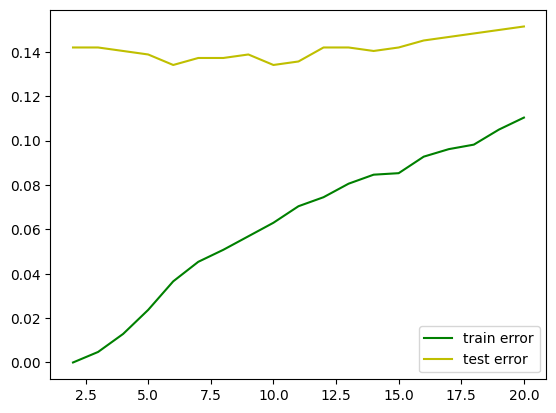

In [31]:
# train and test error parametrized by k

import matplotlib.pyplot as plt

fixed = model_params.pop('fixed')
if fixed:
    param_range = [x / 10 for x in range(10, 21)]
    model_params.pop('window_size')
else:
    param_range = range(2, 21)
    model_params.pop('k')

model_train_error = []
model_test_error = []

for param in param_range:
    if fixed:
        opt_model = KNNClassifier(window_size=param, **model_params)
    else:
        opt_model = KNNClassifier(k=param, **model_params)
    opt_model.fit(X_train, y_train)
    train_error = 1 - accuracy_score(y_train, opt_model.predict(X_train))
    test_error = 1 - accuracy_score(y_test, opt_model.predict(X_test))
    model_train_error.append(train_error)
    model_test_error.append(test_error)

plt.plot(param_range, model_train_error, color='g', label='train error')
plt.plot(param_range, model_test_error, color='y', label='test error')
plt.legend()
plt.show()

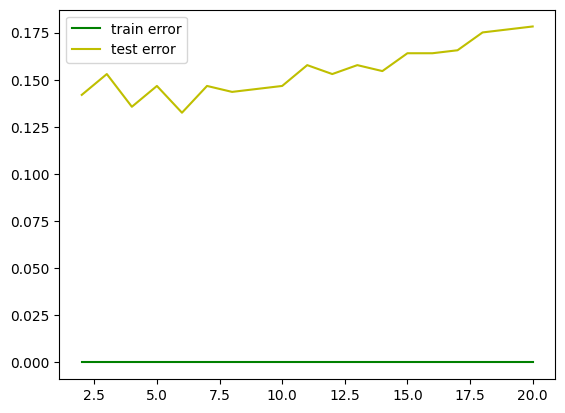

In [32]:
fixed = lib_params.pop('fixed')
if fixed:
    param_range = [x / 10 for x in range(10, 21)]
    lib_params.pop('radius')
else:
    param_range = range(2, 21)
    lib_params.pop('n_neighbors')

lib_train_error = []
lib_test_error = []

for param in param_range:
    if fixed:
        opt_lib = RadiusNeighborsClassifier(radius=param, **lib_params)
    else:
        opt_lib = KNeighborsClassifier(n_neighbors=param, **lib_params)
    opt_lib.fit(X_train, y_train)
    train_error = 1 - opt_lib.score(X_train, y_train)
    test_error = 1 - opt_lib.score(X_test, y_test)
    lib_train_error.append(train_error)
    lib_test_error.append(test_error)

plt.plot(param_range, lib_train_error, color='g', label='train error')
plt.plot(param_range, lib_test_error, color='y', label='test error')
plt.legend()
plt.show()

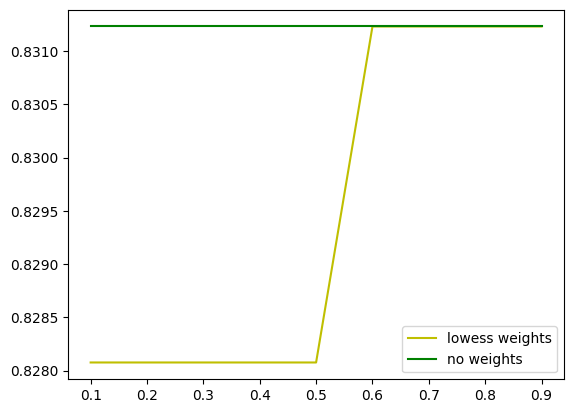

In [33]:
# lowess

def lowess(estimator, X, y):
    anomalies_ind = []
    for i in range(len(X)):
        estimator.fit(np.delete(X, i, axis=0), np.delete(y, i, axis=0))
        entry = np.array([X[i]])
        pred = estimator.predict(entry)
        if y[i] != pred[0]:
            anomalies_ind.append(i)
    return np.array(anomalies_ind)

anomalies = lowess(KNNClassifier(k=3), X_train, y_train)
weights = np.ones(len(X_train))
weight_range = [x / 10 for x in range(1, 10)]
lowess_scores = []

for w in weight_range:
    weights[anomalies] = w
    model_lowess = KNNClassifier(k=3, obj_weights=weights)
    model_lowess.fit(X_train, y_train)
    prediction = model_lowess.predict(X_test)
    lowess_scores.append(accuracy_score(y_test, prediction))

plt.plot(weight_range, lowess_scores, color='y', label='lowess weights')
plt.plot(weight_range, [model_score] * len(weight_range), color='g', label='no weights')
plt.legend()
plt.show()

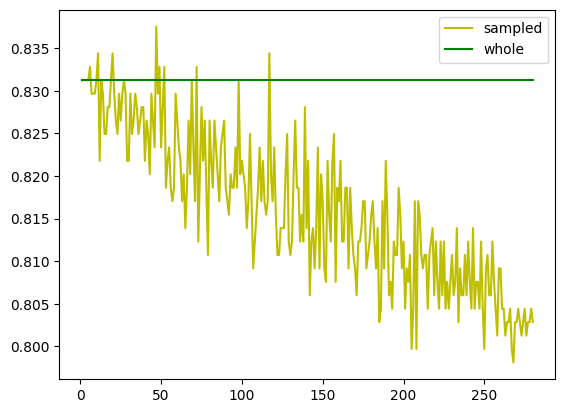

In [34]:
anomalies = lowess(KNeighborsClassifier(n_neighbors=3), X_train, y_train)

lowess_scores = []

anomalies_range = range(1, len(anomalies) + 1)

for n in anomalies_range:
    remove_anomalies = np.random.choice(anomalies, n, replace=False)
    X_train_sample = np.delete(X_train, remove_anomalies, axis=0)
    y_train_sample = np.delete(y_train, remove_anomalies, axis=0)
    lib_lowess = KNeighborsClassifier(n_neighbors=3)
    lib_lowess.fit(X_train_sample, y_train_sample)
    prediction = lib_lowess.predict(X_test)
    lowess_scores.append(accuracy_score(y_test, prediction))

plt.plot(anomalies_range, lowess_scores, color='y', label='sampled')
plt.plot(anomalies_range, [lib_score] * len(anomalies_range), color='g', label='whole')
plt.legend()
plt.show()